In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD 
from torch import nn

In [2]:
import utils_generic as generic
import singletask_simple as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.bert_conf

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

## Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='m1_bert_ABOUT'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5025510204081632 

Using scikit learn accuracy por género en el conjunto about
MALE 0.9635416666666666
FEMALE 0.06 

GLOBAL: 0.5227272727272727 

Using scikit learn accuracy por género en el conjunto to
MALE 0.975669099756691
FEMALE 0.03412073490813648 

GLOBAL: 0.5176010430247718 

Using scikit learn accuracy por género en el conjunto as
MALE 0.9494949494949495
FEMALE 0.05660377358490566 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6808553941366149 	 Validation loss: 0.6766693541559122 	 
  1%|          | 574/57400 [01:22<1:53:44,  8.33it/s]
Epoch 2 	 Training loss: 0.6698202467961594 	 Validation loss: 0.6601083713062739 	 
  2%|▏         | 1148/57400 [02:46<2:10:20,  7.19it/s]
Epoch 3 	 Training loss: 0.6404032520300835 	 Validation loss: 0.6060810129521257 	 
  3%|▎         | 1722/57400 [04:10<1:59:19,  7.78it/s]
Epoch 4 	 Training loss: 0.5580775114717383 	 Validation loss: 0.4991677191297887 	 
  4%|▍         | 2296/57400 [05:35<2:15:37,  6.77it/s]
Epoch 5 	 Training loss: 0.47007232224276674 	 Validation loss: 0.4305276446423288 	 
  5%|▌         | 2870/57400 [06:59<2:09:18,  7.03it/s]
Epoch 6 	 Training loss: 0.42126089100846015 	 Validation loss: 0.3934437233512684 	 
  6%|▌         | 3444/57400 [08:25<2:06:19,  7.12it/s]
Epoch 7 	 Training loss: 0.3955204304087037 	 Validation loss: 0.37299240443666104 	 
  7%|▋         | 4018/57400 [09:54<2:12:06,  6.73it/s]
Epoch 8 	 Training

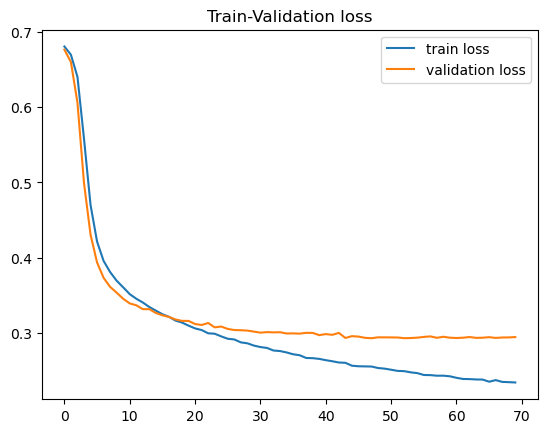

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GLOBAL: 0.8558673469387755 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8645833333333334
FEMALE 0.8475 

GLOBAL: 0.6881313131313131 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6982968369829684
FEMALE 0.6771653543307087 

GLOBAL: 0.6870925684485006 

Using scikit learn accuracy por género en el conjunto as
MALE 0.7045454545454546
FEMALE 0.6684636118598383 



# TO

In [14]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='m1_bert_TO'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693862137167296 	 Validation loss: 0.6942407761589956 	 
  1%|          | 574/57400 [01:23<2:26:30,  6.46it/s]
Epoch 2 	 Training loss: 0.693786780074083 	 Validation loss: 0.693226303084422 	 
  2%|▏         | 1148/57400 [02:45<1:48:14,  8.66it/s]
Epoch 3 	 Training loss: 0.6936131817538563 	 Validation loss: 0.6927743028786223 	 
  3%|▎         | 1722/57400 [04:07<2:08:00,  7.25it/s]
Epoch 4 	 Training loss: 0.6937310396586561 	 Validation loss: 0.6927815180713848 	 
  4%|▍         | 2296/57400 [05:29<1:58:35,  7.74it/s]
Epoch 5 	 Training loss: 0.6935868564383079 	 Validation loss: 0.6926904320716858 	 
  5%|▌         | 2870/57400 [06:52<1:53:58,  7.97it/s]
Epoch 6 	 Training loss: 0.6936948894415998 	 Validation loss: 0.6932581450979588 	 
  6%|▌         | 3444/57400 [08:14<2:04:44,  7.21it/s]
Epoch 7 	 Training loss: 0.6937115758345933 	 Validation loss: 0.6918289873559597 	 
  7%|▋         | 4018/57400 [09:37<2:02:51,  7.24it/s]
Epoch 8 	 Training loss:

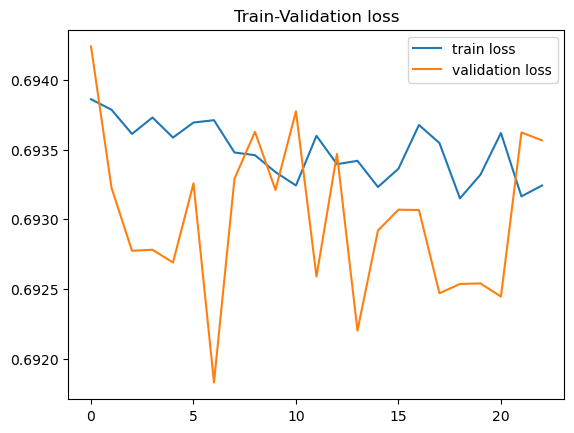

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [17]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GLOBAL: 0.4961734693877551 

Using scikit learn accuracy por género en el conjunto about
MALE 0.15104166666666666
FEMALE 0.8275 

GLOBAL: 0.48737373737373735 

Using scikit learn accuracy por género en el conjunto to
MALE 0.17761557177615572
FEMALE 0.821522309711286 

GLOBAL: 0.4771838331160365 

Using scikit learn accuracy por género en el conjunto as
MALE 0.12626262626262627
FEMALE 0.8517520215633423 



# AS

In [18]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='m1_bert_AS'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.48086734693877553 

Using scikit learn accuracy por género en el conjunto about
MALE 0.2994791666666667
FEMALE 0.655 

GLOBAL: 0.5126262626262627 

Using scikit learn accuracy por género en el conjunto to
MALE 0.26520681265206814
FEMALE 0.7795275590551181 

GLOBAL: 0.4915254237288136 

Using scikit learn accuracy por género en el conjunto as
MALE 0.2676767676767677
FEMALE 0.7304582210242587 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6962949969004255 	 Validation loss: 0.6961972955930031 	 
  1%|          | 574/57400 [01:21<2:04:48,  7.59it/s]
Epoch 2 	 Training loss: 0.6956871692934934 	 Validation loss: 0.6935090968164347 	 
  2%|▏         | 1148/57400 [02:42<2:17:36,  6.81it/s]
Epoch 3 	 Training loss: 0.6946348802345556 	 Validation loss: 0.6938213827246327 	 
  3%|▎         | 1722/57400 [04:04<2:33:16,  6.05it/s]
Epoch 4 	 Training loss: 0.6945944302796486 	 Validation loss: 0.6928143784151239 	 
  4%|▍         | 2296/57400 [05:27<2:29:16,  6.15it/s]
Epoch 5 	 Training loss: 0.6941404512950352 	 Validation loss: 0.6929093649831869 	 
  5%|▌         | 2870/57400 [06:49<2:00:09,  7.56it/s]
Epoch 6 	 Training loss: 0.6940073360549448 	 Validation loss: 0.6919483198957929 	 
  6%|▌         | 3444/57400 [08:11<2:07:35,  7.05it/s]
Epoch 7 	 Training loss: 0.6939978702350776 	 Validation loss: 0.6933557643728742 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [09:33<2:00:56,  7.

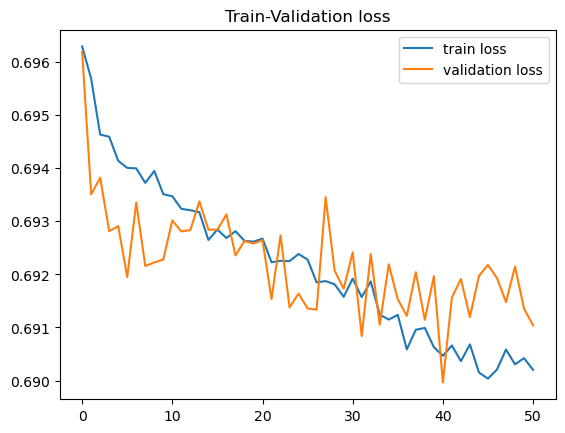

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [21]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GLOBAL: 0.6415816326530612 

Using scikit learn accuracy por género en el conjunto about
MALE 0.6354166666666666
FEMALE 0.6475 

GLOBAL: 0.61489898989899 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6423357664233577
FEMALE 0.5853018372703412 

GLOBAL: 0.6258148631029987 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6060606060606061
FEMALE 0.6469002695417789 

